# Demo Notebook - Training cp_line_simple

This is a notebook that demonstrates how cp_line_simple can be invoked and trained.

For this demo, est_lib is first used to retrieve seismic data from four stations that
are part of the Canadian National Seismograph Network (CNSN). The four stations are

[HOLB,PACB,WOSB,HOPB]

The seismic data will be from two earthquake events.

1. Event 1
   ```
   Magnitude: 6.3
   Origin   : [50.6081,-129.9656]
   Time     : 2019-12-25T03:36:01 UTC
   ```

2. Event 2
   ```
   Magnitude: 6.0
   Origin   : [+50.517,-129.757]
   Time     : 2019-12-23T20:56:23 UTC

Following this, `cp_line_simple` is initialized The data from Event 1 will be used to
train the network. Following this, we run test the inference capabilities of the
trained model on data from Event 2.

## Step 1 - Import all Necessary Packages

In [1]:
# Basic Imports
import os
from est_lib.util.obspy_util import *
from est_lib.util.obspy_plot import ray_plot_multi
from obspy import UTCDateTime as dt
from tqdm.notebook import tqdm
import numpy as np
import random

In [2]:
# Torch and Neural Network Imports
import torch
from est_lib.dataset.seismic_dataset_new import EQDataset, get_device
from est_lib.nn.cp_line_simple import cp_line_simple
from torch.utils.tensorboard import SummaryWriter

In [3]:
#Set the seed of Pseudo Random Number Generators
'''
This step is important in order to make results reproducible. ML
frameworks perform a random initialization of model weights when
a neural network is initialized. By setting the seed of the random
generator, one can guarantee reproduce behavior every time the notebook
is reset.
'''
torch.manual_seed(42)
random.seed(0)
np.random.seed(0)

In [4]:
# Create a Local Directory to Store Working Files
test_name = "Demo-{}-training".format(str(dt.now()).replace(':','.'))
writer_path = os.path.join('.',test_name)
if(not os.path.isdir(writer_path)):
    os.mkdir(writer_path)
writer = SummaryWriter(writer_path)
filepath = os.path.abspath(writer_path)

## Step 2 - Retrieve Seismic Data

In [5]:
# Specify Station, Channel and Event Information
sta_list = ['HOLB','PACB','WOSB','HOPB']
cha_list = ['HHE','HHN','HHZ']

event1 = ('6.3',50.6081,-129.9656,"2019-12-25T03:36:01.578000Z")
event2 = ('6.0',+50.517,-129.757,"2019-12-23T20:56:23.555000Z")

horizon = 20000

In [6]:
# First, Retrieve Station Metadata
inv = inventory_retriever(network="CN",
                              sta_list=sta_list,
                              level='response')
# Write Metadata to Working Directory
inv_file = inventory_writer(inv,
                            os.path.join(filepath,'inv.xml'),
                            file_format="STATIONXML")
sb = 600
sa = 1800

# Retrieve Seismic Data Corresponding to Event 1
'''
Note that the data is collected in parts. Neural networks are essentially
trained by providing samples of Inputs and Outputs. For the current demo
we intend to train the network using data from stations HOLB,PACB & WOSB
and then have it predict the seismic waveform at HOPB.
'''

# Retrieve Event 1 Waveforms from HOLB,PACB & WOSB
ev_1_train_x = stream_retriever(event_time = dt(event1[3]),
                          seconds_before = sb,
                          seconds_after = sa,
                          network="CN",
                          sta_list=sta_list[0:-1],
                          channel_list=cha_list)

# Retrieve Event 1 Waveform from HOPB
ev_1_train_y = stream_retriever(event_time = dt(event1[3]),
                          seconds_before = sb,
                          seconds_after = sa,
                          network="CN",
                          sta_list=sta_list[-1:],
                          channel_list=cha_list)

# Retrieve Seismic Data Corresponding to Event 2

# Retrieve Event 2 Waveforms from HOLB,PACB & WOSB
ev_2_test_x = stream_retriever(event_time = dt(event2[3]),
                          seconds_before = sb,
                          seconds_after = sa,
                          network="CN",
                          sta_list=sta_list[0:-1],
                          channel_list=cha_list)

# Retrieve Event 2 Waveform from HOPB
ev_2_test_y = stream_retriever(event_time = dt(event2[3]),
                          seconds_before = sb,
                          seconds_after = sa,
                          network="CN",
                          sta_list=sta_list[-1:],
                          channel_list=cha_list)

## Step 3 - Clean the Data

The seismic data is cleaned by first passing it through a low-pass filter
and then we remove the instrument response from the data to get raw measurements
of ground motion (in terms of velocity).

In [7]:
# Filter Out Noise
ev_1_train_x.filter(type='bandpass',freqmin=0.01,freqmax=4)
ev_1_train_y.filter(type='bandpass',freqmin=0.01,freqmax=4)
ev_2_test_x.filter(type='bandpass',freqmin=0.01,freqmax=4)
ev_2_test_y.filter(type='bandpass',freqmin=0.01,freqmax=4)

'''
NOTE: Instead of a low pass filter, a bandpass filter with a lower
cutoff close to 0 Hz is used.
'''

'\nNOTE: Instead of a low pass filter, a bandpass filter with a lower\ncutoff close to 0 Hz is used.\n'

In [8]:
# Remove Instrument Response
ev_1_train_x.remove_response(inventory=inv)
ev_1_train_y.remove_response(inventory=inv)
ev_2_test_x.remove_response(inventory=inv)
ev_2_test_y.remove_response(inventory=inv)

3 Trace(s) in Stream:
CN.HOPB..HHE | 2019-12-23T20:46:23.560000Z - 2019-12-23T21:16:23.550000Z | 100.0 Hz, 180000 samples
CN.HOPB..HHN | 2019-12-23T20:46:23.560000Z - 2019-12-23T21:16:23.550000Z | 100.0 Hz, 180000 samples
CN.HOPB..HHZ | 2019-12-23T20:46:23.560000Z - 2019-12-23T21:16:23.550000Z | 100.0 Hz, 180000 samples

## Step 4 - Visualize Seismic Data

In [9]:
plot_stream = ev_1_train_x.select()
for t in ev_1_train_y:
    plot_stream.append(t)
plot_stream

12 Trace(s) in Stream:
CN.HOLB..HHE | 2019-12-25T03:26:01.580000Z - 2019-12-25T03:56:01.570000Z | 100.0 Hz, 180000 samples
CN.HOLB..HHN | 2019-12-25T03:26:01.580000Z - 2019-12-25T03:56:01.570000Z | 100.0 Hz, 180000 samples
CN.HOLB..HHZ | 2019-12-25T03:26:01.580000Z - 2019-12-25T03:56:01.570000Z | 100.0 Hz, 180000 samples
CN.PACB..HHE | 2019-12-25T03:26:01.580000Z - 2019-12-25T03:56:01.570000Z | 100.0 Hz, 180000 samples
CN.PACB..HHN | 2019-12-25T03:26:01.580000Z - 2019-12-25T03:56:01.570000Z | 100.0 Hz, 180000 samples
CN.PACB..HHZ | 2019-12-25T03:26:01.580000Z - 2019-12-25T03:56:01.570000Z | 100.0 Hz, 180000 samples
CN.WOSB..HHE | 2019-12-25T03:26:01.580000Z - 2019-12-25T03:56:01.570000Z | 100.0 Hz, 180000 samples
CN.WOSB..HHN | 2019-12-25T03:26:01.580000Z - 2019-12-25T03:56:01.570000Z | 100.0 Hz, 180000 samples
CN.WOSB..HHZ | 2019-12-25T03:26:01.580000Z - 2019-12-25T03:56:01.570000Z | 100.0 Hz, 180000 samples
CN.HOPB..HHE | 2019-12-25T03:26:01.580000Z - 2019-12-25T03:56:01.570000Z | 10

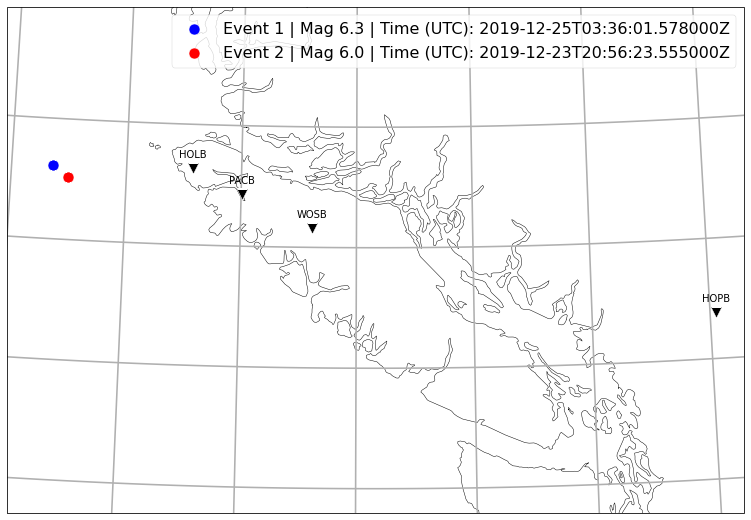

In [10]:
ev_fig = ray_plot_multi(
    ev_lat=[event1[1],event2[1]],
    ev_lon=[event1[2],event2[2]],
    min_lat=47.8,
    max_lat=52.,
    min_lon=-130.5,
    max_lon=-121,
    streams=plot_stream,
    inventory=inv,
    comment=['| Mag {} | Time (UTC): {}'.format(event1[0],event1[3]),
             '| Mag {} | Time (UTC): {}'.format(event2[0],event2[3])])

In [11]:
writer.add_figure('1.Events and Stations',ev_fig,global_step=0)

## Step 5 - Write Seismic Data to Filesystem

Offload the seismic data from memory by writing it to the working directory.

In [12]:
# Write Training Data (Corresponding to Event 1) to the filesystem

train_x_f_path = os.path.join(filepath,'train_x.npy')
train_x_file = stream_data_writer(ev_1_train_x,
                              inv,
                              train_x_f_path,
                              sta_list[0:-1],
                              cha_list)
        
train_y_f_path = os.path.join(filepath,'train_y.npy')
train_y_file = stream_data_writer(ev_1_train_y,
                              inv,
                              train_y_f_path,
                              sta_list[-1:],
                              cha_list)

In [13]:
# Write Testing Data (Corresponding to Event 2) to the filesystem

test_x_f_path = os.path.join(filepath,'test_x.npy')
test_x_file = stream_data_writer(ev_2_test_x,
                              inv,
                              test_x_f_path,
                              sta_list[0:-1],
                              cha_list)
        
test_y_f_path = os.path.join(filepath,'test_y.npy')
test_y_file = stream_data_writer(ev_2_test_y,
                              inv,
                              test_y_f_path,
                              sta_list[-1:],
                              cha_list)

## Step 6 - Prepare Data for the Neural Network

We do a few steps to prep the data so that it might be easily loaded into the
neural network for training and testing.

In [14]:
# Create PyTorch Compatible Dataset Objects
'''
PyTorch provides a DataSet construct (class) that can be used
as a model to build custom DataSet classes for different kinds
of data. EQDataset is one such custom dataset that is available
as part of est_lib.

Reference to PyTorch Documentation: https://pytorch.org/docs/stable/data.html
'''

# Initialize Training Dataset
train_dataset = EQDataset(inv_file,
                    train_x_file,train_y_file,
                    sta_list=sta_list,
                    chan_list=cha_list,
                    ip_dim=len(cha_list),
                    num_nodes=len(sta_list[0:-1]),
                    seq_length=500,horizon=horizon)

# Initialize Testing Dataset
test_dataset = EQDataset(inv_file,
                    test_x_file,test_y_file,
                    sta_list=sta_list,
                    chan_list=cha_list,
                    ip_dim=len(cha_list),
                    num_nodes=len(sta_list[-1:]),
                    seq_length=500,horizon=horizon)

In [15]:
# Instantiate a DataLoader Object
'''
In machine learning, it can be efficient to batch a number of inputs
together and simultaneously evaluate the batch on the network. This is
a way of being more efficient.
'''
batch_len = 1000 # Batch and process 1000 inputs at a time
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_len)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_len)

## Step 7 - Initialize the Neural Network

Next, we initialize the neural network.

In [16]:
# Initialize cp_line_simple
net = cp_line_simple(num_in_nodes=len(sta_list[0:-1]),feat_size=len(cha_list))
# Moves the model into a GPU, if one is available
net = net.to(get_device())

## Step 8 - Preparations for Operating the Neural Network

In [17]:
# Specify Weight Optimization Algorithm
optimizer = torch.optim.Adam(net.parameters(),lr=0.001) # Adam Algorith

# Specify Loss Functions
loss1 = torch.nn.MSELoss(reduction='sum')
loss2 = torch.nn.MSELoss(reduction='sum')
loss3 = torch.nn.MSELoss(reduction='sum')

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
'''
The code in this block consists of a number of helper functions
used to run inference, transform data and create output plots.
'''

# Function to Run Inference and Return pred_array and loss
def run_inference(model,test_data_loader,gen_prediction=False):
    if gen_prediction:
        pred = list()
    model.eval()
    test_losses = torch.zeros(1) # to accumulate losses
    for b,b_input in enumerate(test_data_loader):
        with torch.no_grad():
            x = b_input[0]
            y = b_input[1]
            # Forward Pass
            op = net(x)
            if gen_prediction:
                pred.append(op)
            # Loss Scaling
            scale = list()
            for lnum in range(len(op)):
                predi = max(y[:,:,lnum].detach().cpu())
                if abs(predi) > 0.0001:
                    scale.append(100)
                else:
                    scale.append(1)
            # Loss
            lx = loss1(op[0]*scale[0],y[:,:,0]*scale[0])
            t_loss = lx
            if len(op) > 1:
                ly = loss2(op[1]*scale[1],y[:,:,1]*scale[1])
                t_loss += ly
            if len(op) > 2:
                lz = loss3(op[2]*scale[2],y[:,:,2]*scale[2])
                t_loss += lz
            test_losses+=t_loss.detach().to('cpu')
    total_loss = test_losses / (b+1)
    if gen_prediction:
        return pred,total_loss
    else:
        return total_loss

# Function to Transform Inference Output into Timeseries Numpy Array
def write_op_to_numpy_streams(obj,features,seq_len,horizon):
    res = list()
    for i,op in tqdm(enumerate(obj)):
        if i==0:
            tempx = np.concatenate((np.zeros([seq_len+horizon,1]),op[0].detach().cpu().numpy()))
            if features > 1:
                tempy = np.concatenate((np.zeros([seq_len+horizon,1]),op[1].detach().cpu().numpy()))
            if features > 2:
                tempz = np.concatenate((np.zeros([seq_len+horizon,1]),op[2].detach().cpu().numpy()))
        else:
            tempx = np.concatenate((tempx,op[0].detach().cpu().numpy()))
            if features > 1:
                tempy = np.concatenate((tempy,op[1].detach().cpu().numpy()))
            if features > 2:
                tempz = np.concatenate((tempz,op[2].detach().cpu().numpy()))
    res.append(tempx)
    if features > 1:
        res.append(tempy)
    if features > 2:
        res.append(tempz)
    return res

# Function to Plot Ground Truth vs Prediction
def gen_plots(pred_data,real_data,station,comment='',scale=1):
    fig = plt.figure(figsize=(15,15))
    title_strings = ['East-West','North-South','Up-Down']
    for sp in range(len(pred_data)):
        ax = fig.add_subplot(3,1,sp+1)
        ax.plot((real_data[sp].data)*scale,label='Ground Truth')
        ax.plot(pred_data[sp],label='Predicted')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Ground Velocity (m/s)')
        ax.set_title('Station: {}, Direction: {} {}'.format(station,title_strings[sp],comment))
        plt.grid()
        plt.legend()
    fig.tight_layout()
    plt.show()
    return fig

## Step 9 - Inspect the Performance of the Untrained Network

Before training, we test the untrained model on the test data (Event 2).

In [20]:
# Pass the Test Data into the Network and Print Out the Loss
pre_pred,pre_tst_loss = run_inference(net,test_loader,gen_prediction=True)
print("Pre Trained Model, Loss on Test Set = {}".format(pre_tst_loss))
writer.add_scalar('Test Loss - Untrained',pre_tst_loss,0)

Pre Trained Model, Loss on Test Set = tensor([194357.3750])


0it [00:00, ?it/s]

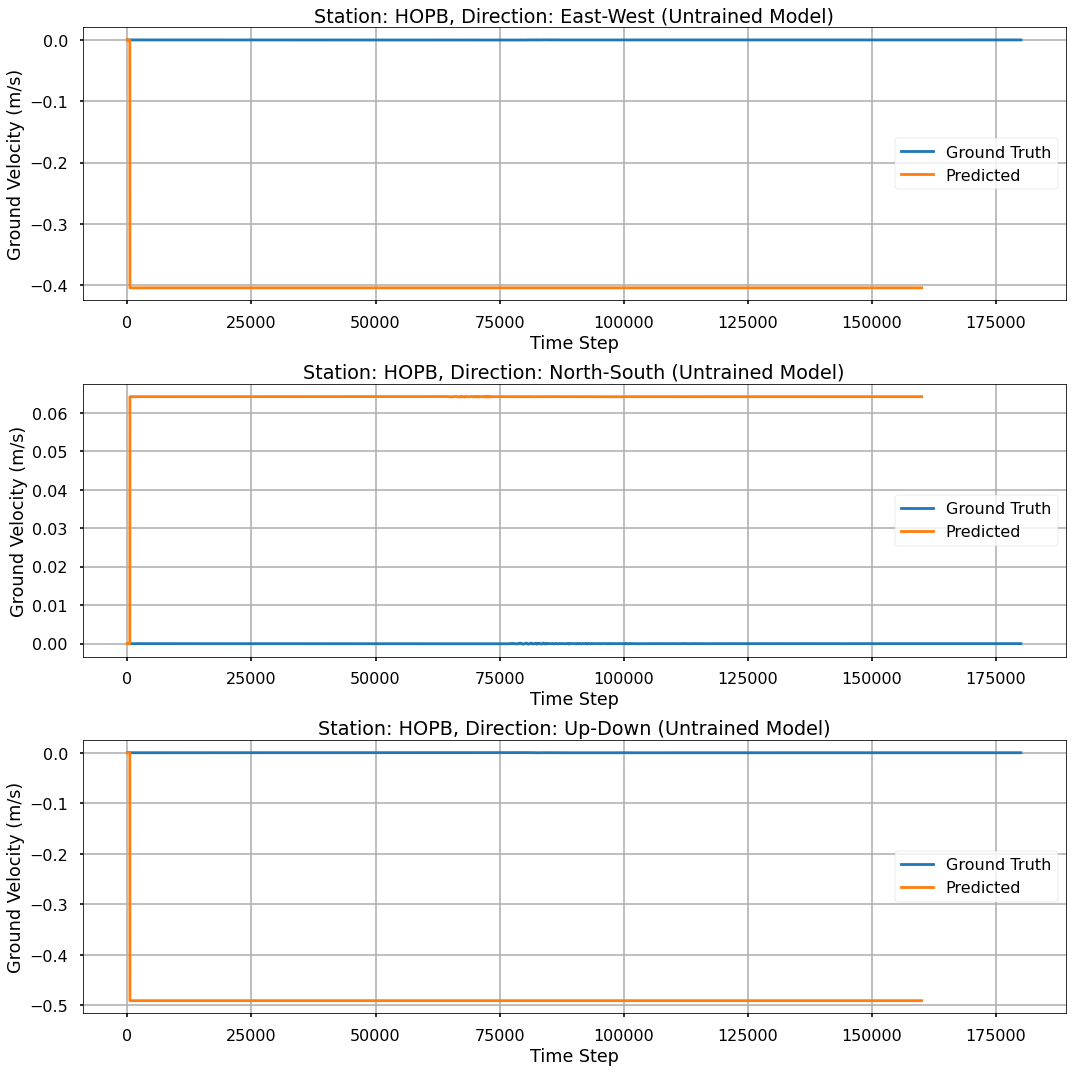

In [21]:
# Visualize the Output Generated by the Untrained Network
pre_inference_op = write_op_to_numpy_streams(pre_pred,test_dataset.ip_dim,test_dataset.seq_length,0)
fig_inference_trained = gen_plots(pre_inference_op,ev_2_test_y,sta_list[-1],comment='(Untrained Model)')
writer.add_figure('2. Untrained Model Prediction at WOSB',fig_inference_trained,global_step=0)

## Step 10 - Train the Neural Network

Finally, we execute the training loop. In each loop,

1. All the training data is passed into the network
2. The network produces an output
3. The output is compared to the ground truth and the loss is computed.
4. The loss (or error) is propagated back to the network and the weights are optimized using the Adam algorithm.

The one pass through the entire loop is called an Epoch.

In [22]:
# The network is trained for 21 Epochs
num_epoch = 21

# Train Loop
for e in tqdm(range(num_epoch)):
    net.train()
    run_loss_train = torch.zeros(1)
    run_loss_test = torch.zeros(1)
    for i,batch in enumerate(train_loader):
        net.zero_grad()
        optimizer.zero_grad()
        x = batch[0]
        y = batch[1]
        # Forward Pass
        op = net(x)
        if e==0 and i==0:
            writer.add_graph(net,x)
        # Loss Scaling
        scale = list()
        for lnum in range(len(op)):
            pred = max(y[:,:,lnum].detach().to('cpu'))
            if abs(pred) > 0.0001:
                scale.append(100)
            else:
                scale.append(1)
        # Loss
        lx = loss1(op[0]*scale[0],y[:,:,0]*scale[0])
        tr_loss = lx
        if len(op) > 1:
            ly = loss2(op[1]*scale[1],y[:,:,1]*scale[1])
            tr_loss += ly
        if len(op) > 2:
            lz = loss3(op[2]*scale[2],y[:,:,2]*scale[2])
            tr_loss += lz
        run_loss_train+=tr_loss.detach().to('cpu')
        tr_loss.backward()
        optimizer.step()
    writer.add_scalar('Train Loss',run_loss_train/(i+1),e)
    # One Test Loop
    t_loss = run_inference(net,test_loader)
    writer.add_scalar('Test Loss',t_loss.detach().to('cpu')/(i+1),e)
    torch.cuda.empty_cache()

  0%|          | 0/21 [00:00<?, ?it/s]

D:\Development\Anaconda\envs\torch-spatio-temporal\lib\site-packages\torch\jit\_trace.py:934: TracerWarning: Encountering a list at the output of the tracer might cause the trace to be incorrect, this is only valid if the container structure does not change based on the module's inputs. Consider using a constant container instead (e.g. for `list`, use a `tuple` instead. for `dict`, use a `NamedTuple` instead). If you absolutely need this and know the side effects, pass strict=False to trace() to allow this behavior.
  module._c._create_method_from_trace(


## Step 11 - After Training, make a Backup of the Trained Model

A backup of the trained model is backed up to the working directory as 'model.pt'

In [23]:
# Save Model Checkpoint
epo = e
f_name = "model.pt"
f_path = os.path.join(writer_path,f_name)
lo = tr_loss

torch.save({
            'epoch': epo,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': lo,
            }, f_path)

## Step 12 - Inspect the Performance of the Trained Network

Similar to Step 9 but this time the network is trained, so we expect different results.

In [24]:
# Pass the Test Data into the Network and Print Out the Loss
new_pred,tst_loss = run_inference(net,test_loader,gen_prediction=True)
print("Loss = {}".format(tst_loss))
writer.add_scalar('Test Loss - Trained',tst_loss,0)

Loss = tensor([0.0150])


0it [00:00, ?it/s]

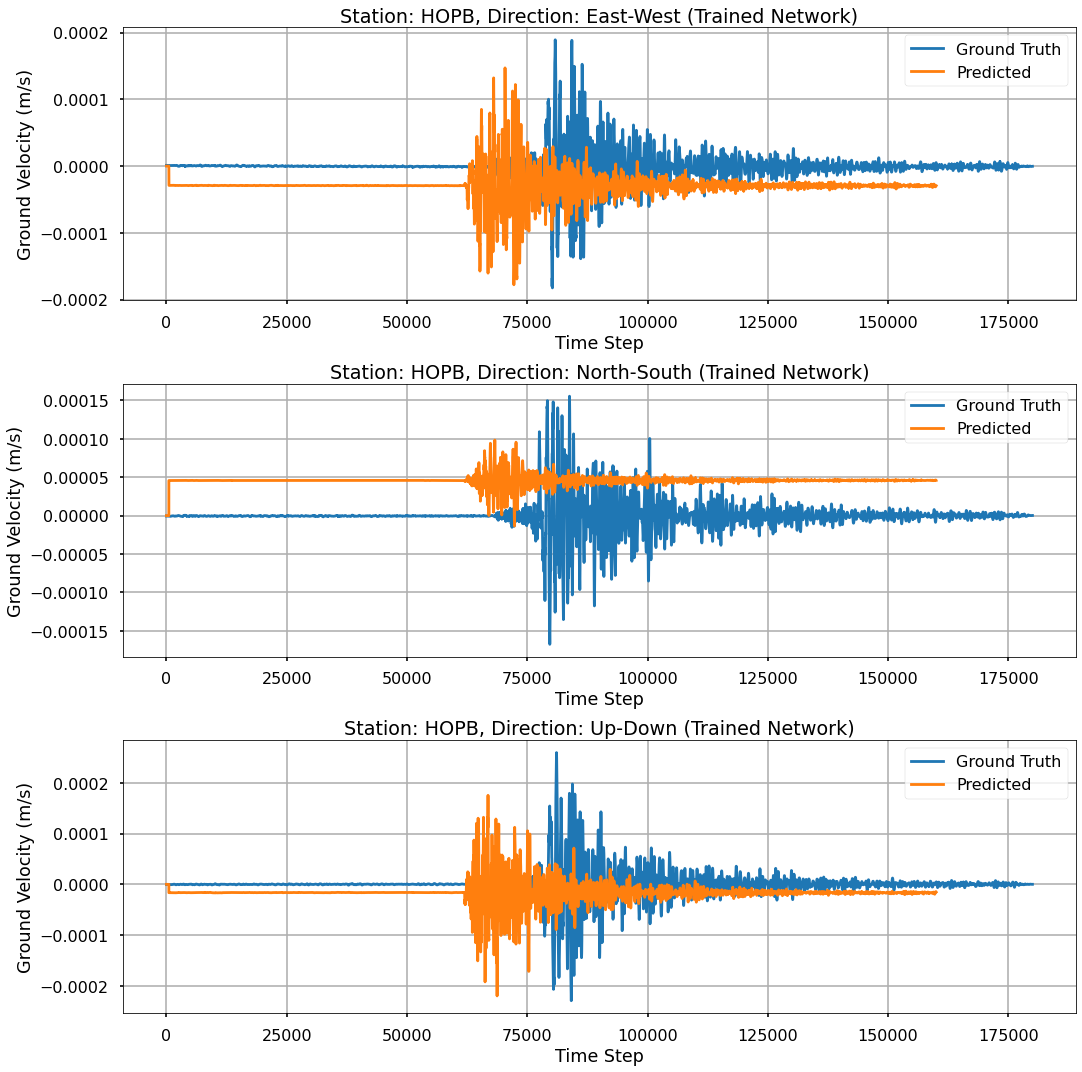

In [25]:
# Visualize the Output Generated by the Untrained Network
inference_op = write_op_to_numpy_streams(new_pred,test_dataset.ip_dim,test_dataset.seq_length,0)
fig_inference_trained = gen_plots(inference_op,ev_2_test_y,sta_list[-1],comment='(Trained Network)')